# Predicting House Sale Prices

In this project, we'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. We can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627). We can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")

Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.

![](https://s3.amazonaws.com/dq-content/240/pipeline.svg)

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    
    train = df[:1460]
    test = df[1460:]
    
    numerical_train = train.select_dtypes(include=['integer', 'float'])
    
    features = numerical_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rsme = np.sqrt(mse)
    
    return rsme

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

## Feature Engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns.

We start by updating `transform_features()` so that any column from the data frame with more than 5%  missing values is dropped. We also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

+ remove features that we don't want to use in the model, just based on the number of missing values or data leakage
+ transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
+ create new features by combining other features

For Handling missing values, we will:

+ All columns:
   + Drop any with 5% or more missing values **for now**.
+ Text columns:
   + Drop any with 1 or more missing values **for now**.
+ Numerical columns:
   + For columns with missing values, fill in with the most common value in that column

1 - All columns: Drop any with 5% or more missing values **for now**.

In [4]:
df_mv = df.isnull().sum()
cutoff_value = len(df)*5/100
df_test = df[df_mv[df_mv < cutoff_value].index]

2 - Text columns: Drop any with 1 or more missing values **for now**.

In [5]:
text_mv_counts = df_test.select_dtypes(include=['object']).isnull().sum()
drop_missing_cols = text_mv_counts[text_mv_counts > 0]
df_test = df_test.drop(drop_missing_cols.index, axis=1)

3 - Numerical columns: For columns with missing values, fill in with the most common value in that column

In [6]:
num_cols = df_test.select_dtypes(include=['int', 'float']).columns
for column in num_cols:
    df_test[column].fillna(df_test[column].mode()[0], inplace=True)

In [7]:
## Verify that every column has 0 missing values
df_test.isnull().sum().value_counts()

0    64
dtype: int64

What new features can we create, that better capture the information in some of the features?

In [8]:
df_test['Years Before Sale'] = df_test['Yr Sold'] - df_test['Year Built']
df_test[df_test['Years Before Sale'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Before Sale
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,1224.0,Ex,TA,PConc,4010.0,0.0,1085.0,5095.0,GasA,Ex,Y,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1


In [9]:
df_test['Years Since Remod'] = df_test['Yr Sold'] - df_test['Year Remod/Add']
df_test[df_test['Years Since Remod'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Before Sale,Years Since Remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,0.0,Gd,TA,PConc,0.0,0.0,1582.0,1582.0,GasA,Ex,Y,1582,570,0,2152,0.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,728.0,Y,0,368,0,0,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,1224.0,Ex,TA,PConc,4010.0,0.0,1085.0,5095.0,GasA,Ex,Y,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,762.0,Ex,TA,PConc,2260.0,0.0,878.0,3138.0,GasA,Ex,Y,3138,1538,0,4676,1.0,0.0,3,1,3,1,Ex,11,Typ,1,3.0,884.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750,0,-1


In [10]:
## Drop rows with negative values for both of these new features
df_test = df_test.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
df_test = df_test.drop(["Year Built", "Year Remod/Add"], axis = 1)

Drop columns that:

+ that aren't useful for ML
+ leak data about the final sale, read more about columns [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)

In [11]:
## Drop columns that aren't useful for ML
df_test = df_test.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
df_test = df_test.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

Let's update the `transform_features()` function.

In [12]:
def transform_features(df):
    
    df_mv = df.isnull().sum()
    cutoff_value = len(df)*5/100
    df = df[df_mv[df_mv < cutoff_value].index]
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols.index, axis=1)
    
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for column in num_cols:
        df[column].fillna(df[column].mode()[0], inplace=True)
    
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    
    train = df[:1460]
    test = df[1460:]
    
    numerical_train = train.select_dtypes(include=['integer', 'float'])
    
    features = numerical_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rsme = np.sqrt(mse)
    
    return rsme

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413066

## Feature Selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

In [13]:
df_num = transform_df.select_dtypes(include=['int64', 'float64'])
corrs = df_num.corr()
sorted_corrs = corrs['SalePrice'].abs().sort_values()
sorted_corrs

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

In [14]:
## Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
final_sorted_corrs = sorted_corrs[sorted_corrs > 0.4]
final_sorted_corrs

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

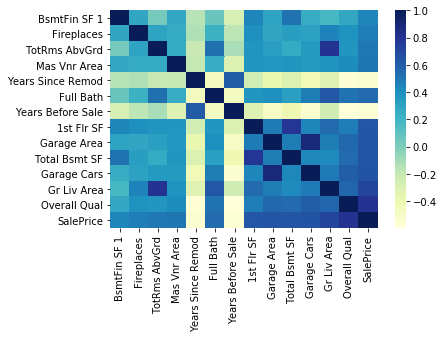

In [15]:
## Generate a correlation heatmap matrix of the numerical features in the training data set.
import seaborn as sns

corrmat = df_num[final_sorted_corrs.index].corr()
sns.heatmap(corrmat, cmap="YlGnBu")
plt.show()

In [16]:
## Keep columns with less than 0.4 correlation with SalePrice
transformed_df = transform_df[final_sorted_corrs.index]
transformed_df

,BsmtFin SF 1,Fireplaces,TotRms AbvGrd,Mas Vnr Area,Years Since Remod,Full Bath,Years Before Sale,1st Flr SF,Garage Area,Total Bsmt SF,Garage Cars,Gr Liv Area,Overall Qual,SalePrice
0,639.0,2,7,112.0,50,1,50,1656,528.0,1080.0,2.0,1656,6,215000
1,468.0,0,5,0.0,49,1,49,896,730.0,882.0,1.0,896,5,105000
2,923.0,0,6,108.0,52,1,52,1329,312.0,1329.0,1.0,1329,6,172000
3,1065.0,2,8,0.0,42,2,42,2110,522.0,2110.0,2.0,2110,7,244000
4,791.0,1,6,0.0,12,2,13,928,482.0,928.0,2.0,1629,5,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,819.0,0,6,0.0,22,1,22,1003,588.0,1003.0,2.0,1003,6,142500
2926,301.0,0,5,0.0,23,1,23,902,484.0,864.0,2.0,902,5,131000
2927,337.0,0,6,0.0,14,1,14,970,0.0,912.0,0.0,970,5,132000
2928,1071.0,1,6,0.0,31,1,32,1389,418.0,1389.0,2.0,1389,5,170000


In [17]:
categorical_df = transform_df.select_dtypes(include=['object'])
categorical_df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,Gd,TA,CBlock,GasA,Ex,Y,Ex,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,GasA,Gd,Y,TA,Typ,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2926,RL,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2927,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,TA,TA,PConc,GasA,TA,Y,TA,Typ,Y
2928,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,TA,TA,CBlock,GasA,Gd,Y,TA,Typ,Y


In [18]:
## How many unique values in each categorical column?
uniqueness_counts = categorical_df.apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

Street           2
Central Air      2
Paved Drive      3
Utilities        3
Land Slope       3
Lot Shape        4
Land Contour     4
Exter Qual       4
Lot Config       5
Kitchen Qual     5
Heating QC       5
Bldg Type        5
Exter Cond       5
Heating          6
Foundation       6
Roof Style       6
MS Zoning        7
Roof Matl        8
Functional       8
House Style      8
Condition 2      8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [19]:
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
categorical_df = categorical_df.drop(drop_nonuniq_cols, axis=1)

categorical_df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,Gd,TA,CBlock,GasA,Ex,Y,Ex,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,CompShg,TA,TA,PConc,GasA,Gd,Y,TA,Typ,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,SLvl,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2926,RL,Pave,IR1,Low,AllPub,Inside,Mod,Norm,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2927,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,SFoyer,Gable,CompShg,TA,TA,PConc,GasA,TA,Y,TA,Typ,Y
2928,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Norm,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,Gd,Y,TA,Typ,Y


In [20]:
for col in categorical_df:
    categorical_df[col] = categorical_df[col].astype('category')

categorical_df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,Gd,TA,CBlock,GasA,Ex,Y,Ex,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,CompShg,TA,TA,PConc,GasA,Gd,Y,TA,Typ,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,SLvl,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2926,RL,Pave,IR1,Low,AllPub,Inside,Mod,Norm,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2927,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,SFoyer,Gable,CompShg,TA,TA,PConc,GasA,TA,Y,TA,Typ,Y
2928,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Norm,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,Gd,Y,TA,Typ,Y


In [21]:
## Create dummy columns and add back to the dataframe!
final_df = pd.concat([
    transformed_df, 
    pd.get_dummies(categorical_df)
], axis=1)

final_df

,BsmtFin SF 1,Fireplaces,TotRms AbvGrd,Mas Vnr Area,Years Since Remod,Full Bath,Years Before Sale,1st Flr SF,Garage Area,Total Bsmt SF,Garage Cars,Gr Liv Area,Overall Qual,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,639.0,2,7,112.0,50,1,50,1656,528.0,1080.0,2.0,1656,6,215000,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,468.0,0,5,0.0,49,1,49,896,730.0,882.0,1.0,896,5,105000,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,923.0,0,6,108.0,52,1,52,1329,312.0,1329.0,1.0,1329,6,172000,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1065.0,2,8,0.0,42,2,42,2110,522.0,2110.0,2.0,2110,7,244000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,791.0,1,6,0.0,12,2,13,928,482.0,928.0,2.0,1629,5,189900,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Update the logic for the `select_features()` function. 

In [22]:
def transform_features(df):
    
    df_mv = df.isnull().sum()
    cutoff_value = len(df)*5/100
    df = df[df_mv[df_mv < cutoff_value].index]
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols.index, axis=1)
    
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for column in num_cols:
        df[column].fillna(df[column].mode()[0], inplace=True)
    
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    
    return df

def select_features(df):
    
    df_num = df.select_dtypes(include=['int64', 'float64'])
    df_cat = df.select_dtypes(include=['object'])
    
    corrs = df_num.corr()
    sorted_corrs = corrs['SalePrice'].abs().sort_values()
    final_sorted_corrs = sorted_corrs[sorted_corrs > 0.4]
    df = df[final_sorted_corrs.index]

    uniqueness_counts = df_cat.apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df_cat = df_cat.drop(drop_nonuniq_cols, axis=1)
    for col in df_cat:
        df_cat[col] = df_cat[col].astype('category')

    df = pd.concat([transformed_df, pd.get_dummies(categorical_df)], axis=1)
     
    return df

def train_and_test(df):
    
    train = df[:1460]
    test = df[1460:]
    
    numerical_train = train.select_dtypes(include=['integer', 'float'])

    features = numerical_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rsme = np.sqrt(mse)
    
    return rsme

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

33367.28718340186

## Train and Test

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named `k` that controls the type of cross validation that occurs.

In [23]:
def transform_features(df):
    
    df_mv = df.isnull().sum()
    cutoff_value = len(df)*5/100
    df = df[df_mv[df_mv < cutoff_value].index]
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols.index, axis=1)
    
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for column in num_cols:
        df[column].fillna(df[column].mode()[0], inplace=True)
    
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    
    return df

def select_features(df):
    
    df_num = df.select_dtypes(include=['int64', 'float64'])
    df_cat = df.select_dtypes(include=['object'])
    
    corrs = df_num.corr()
    sorted_corrs = corrs['SalePrice'].abs().sort_values()
    final_sorted_corrs = sorted_corrs[sorted_corrs > 0.4]
    df = df[final_sorted_corrs.index]

    uniqueness_counts = df_cat.apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df_cat = df_cat.drop(drop_nonuniq_cols, axis=1)
    for col in df_cat:
        df_cat[col] = df_cat[col].astype('category')

    df = pd.concat([transformed_df, pd.get_dummies(categorical_df)], axis=1)
     
    return df

def train_and_test(df, k=0):

    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        
        train = df[:1460]
        test = df[1460:]
    
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rsme = np.sqrt(mse)
    
        return rsme
    
    if k == 1:
        
        np.random.seed(1)
        shuffled_index = np.random.permutation(df.index)
        df = df.reindex(shuffled_index)
        
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        train_one = fold_one
        test_one = fold_two
        train_two = fold_two
        test_two = fold_one
        
        lr.fit(train_one[features], train_one['SalePrice'])
        predictions = lr.predict(test_one[features])
        mse = mean_squared_error(test_one['SalePrice'], predictions)
        rsme_one = np.sqrt(mse)
        
        lr.fit(train_two[features], train_two['SalePrice'])
        predictions = lr.predict(test_two[features])
        mse = mean_squared_error(test_two['SalePrice'], predictions)
        rsme_two = np.sqrt(mse)
        
        rsme = (rsme_one + rsme_two)/2
        
        return rsme
    
    else:
        
        kf = KFold(k, shuffle=True, random_state=1)
        
        from sklearn.model_selection import cross_val_score
        lr = LinearRegression()
        mses = cross_val_score(lr, df[features], df['SalePrice'], scoring='neg_mean_squared_error', cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        rmse = np.mean(rmses)
        
        return rmse
              
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

29111.434972869098